In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the CICIDS2017 dataset. 
# implemented Decision Tree Classifier. 

from matplotlib import table
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sympy import plot_implicit
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/Intrusion_Detection_System_IDS/Advanced_Ensemble_techniques/Stacking/CICIDS2017_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

# Fill nan values
main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())

# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)

sample_df_1 = main_df_2.copy()
# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())


/tmp/ipykernel_186464/1758524713.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


 Extract subsample of data: 
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [2]:
# Label encoding to convert categorical data to numerical data
le = LabelEncoder()
sample_df_1['Label'] = le.fit_transform(sample_df_1['Label'])

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
0     2096484
4      172849
2      128016
10      90819
3       10286
7        5933
6        5385
5        5228
11       3219
1        1953
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [3]:
# Take a 40% random sample of the dataset
# sample_df_1 = sample_df_1.sample(frac=1, random_state=42)

print("Sampled Dataset Overview:")

# feature_names = list(sample_df_1.columns[:-2]) 
# target_names = ['Benign', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttp', 'DoS slowloris', 'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack - Brute Force', 'Web Attack - Sql Injection', 'Web Attack - XSS']

dropped_df = ['Label', 'Flow Packets/s', 'Flow Bytes/s']
X = sample_df_1.drop( dropped_df, axis=1) 
y = sample_df_1['Label']  


Sampled Dataset Overview:


In [4]:

# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Print the number of samples before training
print("Number of samples before training:", len(X_train))

Number of samples before training: 2017889


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8832      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 15)                975       
                                                                 
Total params: 18063 (70.56 KB)
Trainable params: 18063 (70.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
63060/6

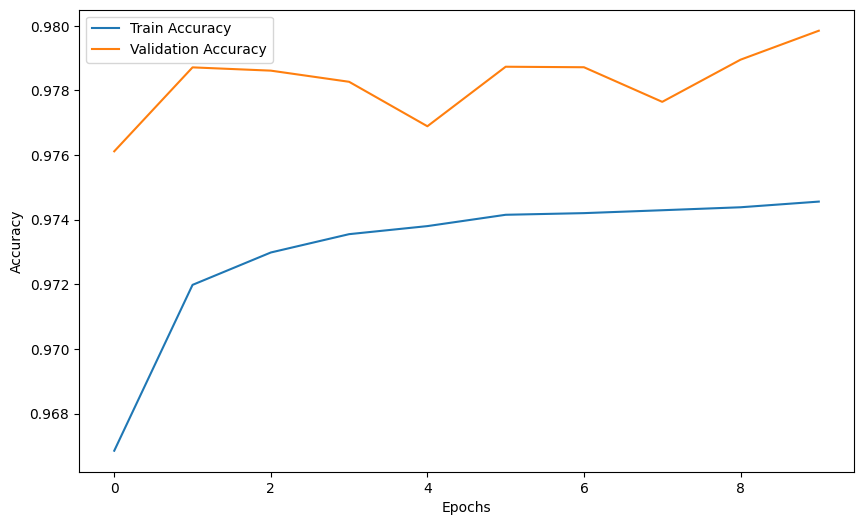

In [7]:
import tensorflow as tf
from keras import layers, models
from sklearn.preprocessing import StandardScaler

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer with the number of features
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(set(y)), activation='softmax')  # Output layer with the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the neural network
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy:.2f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
